## Imports & prep

In [1]:
!pip install sentencepiece transformers

In [2]:
import torch
import numpy as np
import pandas as pd
import gc

## Config

In [3]:
class CFG:
    using_google_colab = False
    drive_mount_location = '/content/drive'
    input_data_location = '../input/feedback-prize-english-language-learning/train.csv'
    test_data_location = '../input/feedback-prize-english-language-learning/test.csv'
    target_metrics = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

## Pretrained embeddings

In [4]:
from transformers import AutoTokenizer, DebertaV2Model

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
deberta = DebertaV2Model.from_pretrained("microsoft/deberta-v3-base")

In [5]:
# Defining a function to extract features from tokens
# tokens -> a tensor with torch.Size([1, <number of tokens>])
# Returns a tensor of shape torch.Size([1, <number of tokens>, 768])
def extract_features(tokens):
    # Extracting features from the essay by chunks of 512 tokens
    features = []
    for i in range(0, tokens.size()[0], 512):
        features.append(deberta(tokens[i:i+512])[0])
    features = torch.cat(features, dim=1)
    return features

# Pooling functions
# input size: [<number of tokens>, 768]
# output size: [768]
def mean_pool_features(features):
    return torch.mean(features, dim=0)
def sum_pool_features(features):
    return torch.sum(features, dim=0)


In [6]:
def essay_to_pooled_features(essay):
    tokens = tokenizer(essay, return_tensors="pt")['input_ids']
    if(device):
        tokens = tokens.to(device)
    features = extract_features(tokens)[0]
    sum_pool = sum_pool_features(features)
    mean_pool = mean_pool_features(features)
    res = mean_pool.cpu().detach()
    return res

## Data loading

In [7]:
if(CFG.using_google_colab):
    from google.colab import drive
    drive.mount(CFG.drive_mount_location)

In [8]:
# Load from CSV
train = pd.read_csv(CFG.input_data_location)

In [9]:
train

text_id                                          full_text  \
0     0016926B079C  I think that students would benefit from learn...   
1     0022683E9EA5  When a problem is a change you have to let it ...   
2     00299B378633  Dear, Principal\n\nIf u change the school poli...   
3     003885A45F42  The best time in life is when you become yours...   
4     0049B1DF5CCC  Small act of kindness can impact in other peop...   
...            ...                                                ...   
3906  FFD29828A873  I believe using cellphones in class for educat...   
3907  FFD9A83B0849  Working alone, students do not have to argue w...   
3908  FFDC4011AC9C  "A problem is a chance for you to do your best...   
3909  FFE16D704B16  Many people disagree with Albert Schweitzer's ...   
3910  FFED00D6E0BD  Do you think that failure is the main thing fo...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  
0          3.5     3.5         3.0          3.0      4.0          3.0  
1          2.5     2.5         3.0          2.0      2.0          2.5  
2          3.0     3.5         3.0          3.0      3.0          2.5  
3          4.5     4.5         4.5          4.5      4.0          5.0  
4          2.5     3.0         3.0          3.0      2.5          2.5  
...        ...     ...         ...          ...      ...          ...  
3906       2.5     3.0         3.0          3.5      2.5          2.5  
3907       4.0     4.0         4.0          4.0      3.5          3.0  
3908       2.5     3.0         3.0          3.0      3.5          3.0  
3909       4.0     4.5         4.5          4.0      4.5          4.5  
3910       3.5     2.5         3.5          3.0      3.0          3.5  

[3911 rows x 8 columns]

## Using GPU

In [10]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [11]:
deberta.eval()
deberta = deberta.to(device)

## Preprocessing

In [12]:
# Replace line breaks with the special symbol '[BR]' 
train['full_text'] = train['full_text'].apply(lambda essay: essay.replace('\n', '[BR]'))

In [13]:
torch.cuda.empty_cache()

In [14]:
gc.collect()

72

In [15]:
# Precompute features
train['features'] = train['full_text'].apply(essay_to_pooled_features)

In [16]:
train['features']

0       [tensor(-0.1695), tensor(-0.0974), tensor(0.29...
1       [tensor(-0.1532), tensor(-0.0169), tensor(0.40...
2       [tensor(-0.1667), tensor(-0.0796), tensor(0.46...
3       [tensor(-0.1325), tensor(0.0023), tensor(0.349...
4       [tensor(-0.1824), tensor(-0.1195), tensor(0.36...
                              ...                        
3906    [tensor(-0.1485), tensor(-0.1734), tensor(0.37...
3907    [tensor(-0.1227), tensor(0.0332), tensor(0.248...
3908    [tensor(-0.2086), tensor(-0.1126), tensor(0.34...
3909    [tensor(-0.2825), tensor(0.0176), tensor(0.368...
3910    [tensor(-0.2389), tensor(0.0608), tensor(0.371...
Name: features, Length: 3911, dtype: object

## Final Data Set 

In [18]:
train

text_id                                          full_text  \
0     0016926B079C  I think that students would benefit from learn...   
1     0022683E9EA5  When a problem is a change you have to let it ...   
2     00299B378633  Dear, Principal[BR][BR]If u change the school ...   
3     003885A45F42  The best time in life is when you become yours...   
4     0049B1DF5CCC  Small act of kindness can impact in other peop...   
...            ...                                                ...   
3906  FFD29828A873  I believe using cellphones in class for educat...   
3907  FFD9A83B0849  Working alone, students do not have to argue w...   
3908  FFDC4011AC9C  "A problem is a chance for you to do your best...   
3909  FFE16D704B16  Many people disagree with Albert Schweitzer's ...   
3910  FFED00D6E0BD  Do you think that failure is the main thing fo...   

      cohesion  syntax  vocabulary  phraseology  grammar  conventions  \
0          3.5     3.5         3.0          3.0      4.0          3.0   
1          2.5     2.5         3.0          2.0      2.0          2.5   
2          3.0     3.5         3.0          3.0      3.0          2.5   
3          4.5     4.5         4.5          4.5      4.0          5.0   
4          2.5     3.0         3.0          3.0      2.5          2.5   
...        ...     ...         ...          ...      ...          ...   
3906       2.5     3.0         3.0          3.5      2.5          2.5   
3907       4.0     4.0         4.0          4.0      3.5          3.0   
3908       2.5     3.0         3.0          3.0      3.5          3.0   
3909       4.0     4.5         4.5          4.0      4.5          4.5   
3910       3.5     2.5         3.5          3.0      3.0          3.5   

                                               features  
0     [tensor(-0.1695), tensor(-0.0974), tensor(0.29...  
1     [tensor(-0.1532), tensor(-0.0169), tensor(0.40...  
2     [tensor(-0.1667), tensor(-0.0796), tensor(0.46...  
3     [tensor(-0.1325), tensor(0.0023), tensor(0.349...  
4     [tensor(-0.1824), tensor(-0.1195), tensor(0.36...  
...                                                 ...  
3906  [tensor(-0.1485), tensor(-0.1734), tensor(0.37...  
3907  [tensor(-0.1227), tensor(0.0332), tensor(0.248...  
3908  [tensor(-0.2086), tensor(-0.1126), tensor(0.34...  
3909  [tensor(-0.2825), tensor(0.0176), tensor(0.368...  
3910  [tensor(-0.2389), tensor(0.0608), tensor(0.371...  

[3911 rows x 9 columns]

In [19]:
class MyDataset(torch.utils.data.Dataset):  
    def __init__(self, pd_data):
        self.data = pd_data['features'].values
        self.target = pd_data[CFG.target_metrics].values
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
  
    def __len__(self):
        return len(self.data)

In [20]:
train_dataset = MyDataset(train[100:])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 128,
                                              shuffle=True)

In [21]:
eval_dataset = MyDataset(train[:100])
eval_loader = torch.utils.data.DataLoader(eval_dataset,
                                           batch_size = 128,
                                              shuffle=False)

## Model creation

In [22]:
# Using feature pooling
class PoolingNN(torch.nn.Module):
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        super().__init__()
        self.c2o = torch.nn.Linear(input_size, output_size)
        self.double()
    def halfRound(self, data):
        return torch.round(data * 2) / 2
    def forward(self, data):
        output = self.c2o(data)
        output = torch.clamp(output, 0, 5)
        return output
    def to(self, device):
        self.device = device
        return super().to(device)

In [23]:
OUTPUT_FEATURES = 6

In [24]:
FEATURES_FROM_DEBERTA = train['features'].values[0].size()[0]

In [25]:
model = PoolingNN(FEATURES_FROM_DEBERTA, OUTPUT_FEATURES).to(device)

In [26]:
model

PoolingNN(
  (c2o): Linear(in_features=768, out_features=6, bias=True)
)

## Training criterion

In [27]:
def RMSE(output, target):
  mse = torch.nn.MSELoss()
  return torch.sqrt(mse(output, target))

In [28]:
criterion = RMSE # mean squared error

optimizer = torch.optim.Adam(model.parameters())

## Training

In [30]:
!nvidia-smi


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Thu Dec 29 11:34:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/

In [31]:
torch.cuda.empty_cache()
gc.collect()

273

In [32]:
def eval_essay(essay_full_text):
    embedding = essay_to_pooled_features(essay_full_text)
    embedding = embedding.to(device).double()
    result = model(embedding)
    return result.cpu().detach()

In [33]:
import time
start_time = time.time()

training_progress_loss = []
eval_progress_loss = []
train_loss = 1
eval_loss = 0
epoch = 0
while((epoch < 10) or (eval_progress_loss[-1] - training_progress_loss[-1] < 0.01) ):
    if(epoch >= 20 and eval_progress_loss[-1] > 1): # Reset if the progress is too slow
        print("Resetting...")
        model = PoolingNN(FEATURES_FROM_DEBERTA, OUTPUT_FEATURES).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        epoch = 0
    eval_loss = 0
    train_loss = 0
    model.train()

    epoch += 1
    total = len(train_loader)
    for data, target in train_loader:
        data, target = data.to(device), target.to(device) #send to GPU
        output = model(data.double())
    
        loss = criterion(output, target)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        model.zero_grad()

    train_loss /= len(train_loader)
    training_progress_loss.append(train_loss)
    model.eval()
    for data, target in eval_loader:
        data, target = data.to(device), target.to(device) #send to GPU
        output = model(data.double())
        loss = criterion(output, target)
        eval_loss += loss.item()
        eval_loss /= len(eval_loader)
        eval_progress_loss.append(eval_loss)
    if(epoch % 10 == 0):
        print("Epoch:", epoch)
        print("Training loss:", training_progress_loss[-1])
        print("Evaluation loss:", eval_progress_loss[-1])
        print("Eval - Train loss:", eval_progress_loss[-1] - training_progress_loss[-1])
        print()
print("Training took %s seconds" % round(time.time() - start_time, 2))

Epoch: 10
Training loss: 1.856162023681091
Evaluation loss: 1.8250202918224916
Eval - Train loss: -0.031141731858599364

Epoch: 20
Training loss: 1.8540182708230462
Evaluation loss: 1.824877376462544
Eval - Train loss: -0.029140894360502045

Resetting...
Epoch: 10
Training loss: 0.46295311783711285
Evaluation loss: 0.45441644580437646
Eval - Train loss: -0.008536672032736392

Epoch: 20
Training loss: 0.455015366935988
Evaluation loss: 0.44736315115458064
Eval - Train loss: -0.0076522157814073455

Epoch: 30
Training loss: 0.44630947768537416
Evaluation loss: 0.44454908605577087
Eval - Train loss: -0.0017603916296032862

Epoch: 40
Training loss: 0.44203843470030235
Evaluation loss: 0.4509335015969422
Eval - Train loss: 0.008895066896639825

Training took 3.82 seconds


In [34]:
model.eval()

PoolingNN(
  (c2o): Linear(in_features=768, out_features=6, bias=True)
)

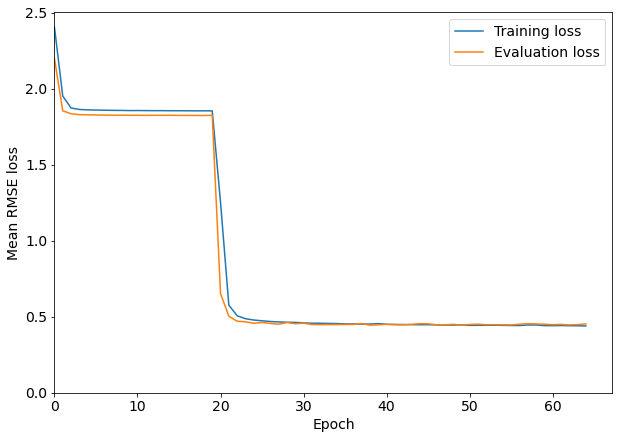

In [35]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.xlabel("Epoch")
plt.ylabel("Mean RMSE loss")
plt.plot(training_progress_loss, label="Training loss")
plt.plot(eval_progress_loss, label="Evaluation loss")
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend()
plt.show()

In [36]:
# Testing phase

In [37]:
test = pd.read_csv(CFG.test_data_location)

In [38]:
test['full_text'] = test['full_text'].apply(lambda essay: essay.replace('\n', '[BR]'))

In [39]:
test

text_id                                          full_text
0  0000C359D63E  when a person has no experience on a job their...
1  000BAD50D026  Do you think students would benefit from being...
2  00367BB2546B  Thomas Jefferson once states that "it is wonde...

In [40]:
test[CFG.target_metrics] = test['full_text'].apply(lambda essay: pd.Series(eval_essay(essay)))

In [41]:
test

text_id                                          full_text  cohesion  \
0  0000C359D63E  when a person has no experience on a job their...  2.902959   
1  000BAD50D026  Do you think students would benefit from being...  2.674631   
2  00367BB2546B  Thomas Jefferson once states that "it is wonde...  3.628387   

     syntax  vocabulary  phraseology   grammar  conventions  
0  2.825807    3.144065     2.979415  2.501739     2.613967  
1  2.565942    2.833212     2.391450  2.055039     2.692138  
2  3.425872    3.569786     3.547451  3.250447     3.168504

In [42]:
output = test[['text_id'] + CFG.target_metrics]

In [43]:
output.to_csv('submission.csv', index=False)